<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%206%20/%20Tugas%20/%20Tensorflow_DeteksiSarkasme_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library and Dataset

In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import json
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import keras_tuner as kt

print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Model hyperparameters
num_words = 10000
maxlen = 50

# Load data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

file_path = "DeteksiSarkasme.json"

data = load_data(file_path)

# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['processed_headline'] = data['headline'].apply(preprocess_text)

In [4]:
# Tokenization and padding
tokenizer = Tokenizer(num_words, oov_token='<UNK>')
tokenizer.fit_on_texts(data['processed_headline'])
sequences = tokenizer.texts_to_sequences(data['processed_headline'])
padded_sequences = pad_sequences(sequences, maxlen, padding='post')
vocab_size = min(num_words, len(tokenizer.word_index) + 1)

# Train-test split
x = padded_sequences
y = np.array(data['is_sarcastic'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#RNN

In [6]:
# Model builder
def build_model(hp):
    model = keras.Sequential()
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=1024, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              input_length=maxlen))

    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    rnn_units = hp.Int('rnn_units', min_value=32, max_value=1024, step=32)
    model.add(layers.SimpleRNN(rnn_units))

    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner',
    project_name='sarcasm_detection'
)

# Search for the best hyperparameters
tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- RNN Units: {best_hps.get('rnn_units')}")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# Train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Trial 30 Complete [00h 01m 53s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.8467477560043335
Total elapsed time: 00h 25m 34s
Best Hyperparameters:
- Embedding Dimension: 416
- RNN Units: 160
- Dense Units: 64
- Dropout Rate: 0.30000000000000004
- Learning Rate: 0.00011358418597630109
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5947 - loss: 0.6501 - val_accuracy: 0.8131 - val_loss: 0.4393
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8263 - loss: 0.4047 - val_accuracy: 0.8336 - val_loss: 0.3929
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8892 - loss: 0.2863 - val_accuracy: 0.8393 - val_loss: 0.4203
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9189 - loss: 0.2175 - val_accuracy: 0.8430 - val_loss: 0.4644
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9361 - loss: 0.1767 - val_accuracy: 0.8400 - val_loss: 0.4996
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - 

In [7]:
# Evaluation
y_prob = model.predict(x_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f1_sq = f1_score(y_test, y_pred)**2
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy : 0.8224
Precision: 0.8429
Recall: 0.7319
F1 Score: 0.7835
F1 Squared: 0.6138
AUC: 0.9009


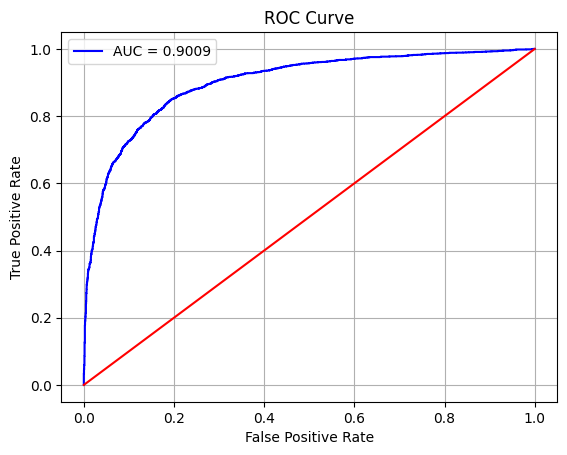

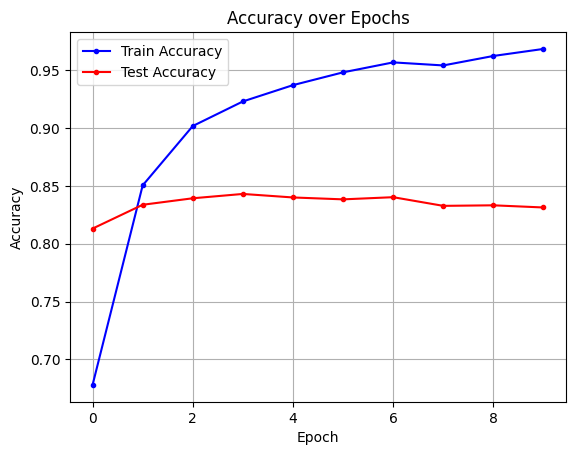

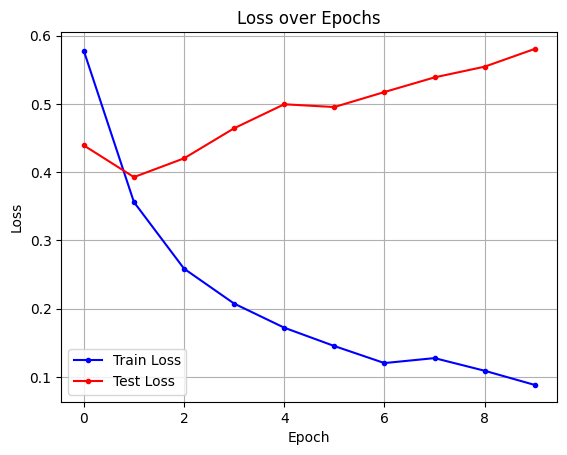

In [8]:
# ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy graph
plt.figure()
plt.plot(history.history['accuracy'], label="Train Accuracy", color='blue', marker='.')
plt.plot(history.history['val_accuracy'], label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(history.history['loss'], label="Train Loss", color='blue', marker='.')
plt.plot(history.history['val_loss'], label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#LSTM

In [14]:
# Model builder
def build_model(hp):
    model = keras.Sequential()

    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=1024, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              input_length=maxlen))

    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    lstm_units = hp.Int('lstm_units', min_value=32, max_value=1024, step=32)
    model.add(layers.LSTM(lstm_units, activation='tanh'))

    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='tanh'
    ))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_lstm',
    project_name='sarcasm_detection_lstm'
)

# Search for the best hyperparameters
tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- LSTM Units: {best_hps.get('lstm_units')}")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# Train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Trial 30 Complete [00h 03m 05s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.8481516242027283
Total elapsed time: 00h 36m 20s
Best Hyperparameters:
- Embedding Dimension: 832
- LSTM Units: 608
- Dense Units: 80
- Dropout Rate: 0.30000000000000004
- Learning Rate: 0.0014228991299728982
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5399 - loss: 0.6966 - val_accuracy: 0.5538 - val_loss: 0.6882
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.5519 - loss: 0.6888 - val_accuracy: 0.5538 - val_loss: 0.6887
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5581 - loss: 0.6882 - val_accuracy: 0.5538 - val_loss: 0.6879
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5587 - loss: 0.6876 - val_accuracy: 0.5538 - val_loss: 0.6875
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5522 - loss: 0.6928 - val_accuracy: 0.6664 - val_loss: 0.6215
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms

In [15]:
# Evaluation
y_prob = model.predict(x_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f1_sq = f1_score(y_test, y_pred)**2
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy : 0.8373
Precision: 0.8003
Recall: 0.8389
F1 Score: 0.8191
F1 Squared: 0.6710
AUC: 0.9134


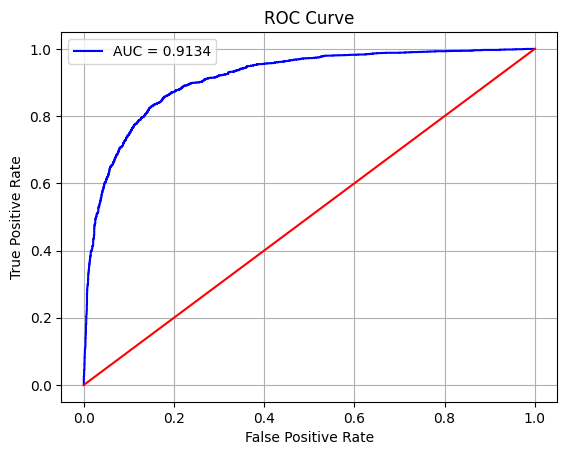

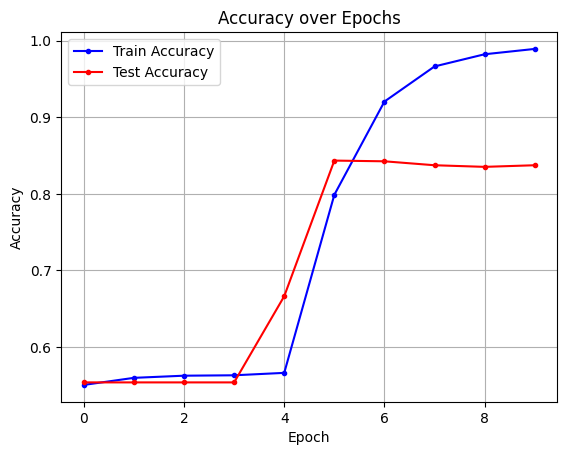

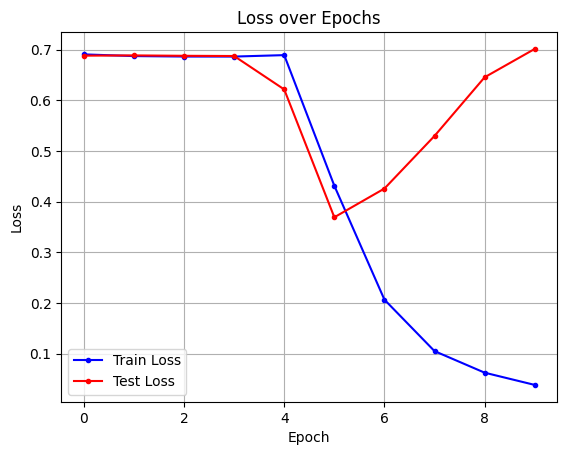

In [16]:
# ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy graph
plt.figure()
plt.plot(history.history['accuracy'], label="Train Accuracy", color='blue', marker='.')
plt.plot(history.history['val_accuracy'], label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(history.history['loss'], label="Train Loss", color='blue', marker='.')
plt.plot(history.history['val_loss'], label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#GRU

In [17]:
# Model builder
def build_model(hp):
    model = keras.Sequential()

    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=1024, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              input_length=maxlen))

    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    gru_units = hp.Int('gru_units', min_value=32, max_value=1024, step=32)
    model.add(layers.GRU(gru_units, activation='tanh'))

    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='tanh'
    ))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_gru',
    project_name='sarcasm_detection_gru'
)

# Search for the best hyperparameters
tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- GRU Units: {best_hps.get('gru_units')}")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# Train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Trial 30 Complete [00h 01m 42s]
val_accuracy: 0.638745903968811

Best val_accuracy So Far: 0.8296677470207214
Total elapsed time: 00h 25m 36s
Best Hyperparameters:
- Embedding Dimension: 512
- GRU Units: 224
- Dense Units: 80
- Dropout Rate: 0.2
- Learning Rate: 0.006914666564817588
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6541 - loss: 0.6315 - val_accuracy: 0.8498 - val_loss: 0.3581
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8803 - loss: 0.2943 - val_accuracy: 0.8386 - val_loss: 0.4251
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9399 - loss: 0.1621 - val_accuracy: 0.8236 - val_loss: 0.5199
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9626 - loss: 0.1096 - val_accuracy: 0.8283 - val_loss: 0.5871
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9714 - loss: 0.0786 - val_accuracy: 0.8154 - val_loss: 0.7003
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9773

In [18]:
# Evaluation
y_prob = model.predict(x_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f1_sq = f1_score(y_test, y_pred)**2
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy : 0.8216
Precision: 0.8119
Recall: 0.7728
F1 Score: 0.7919
F1 Squared: 0.6271
AUC: 0.8921


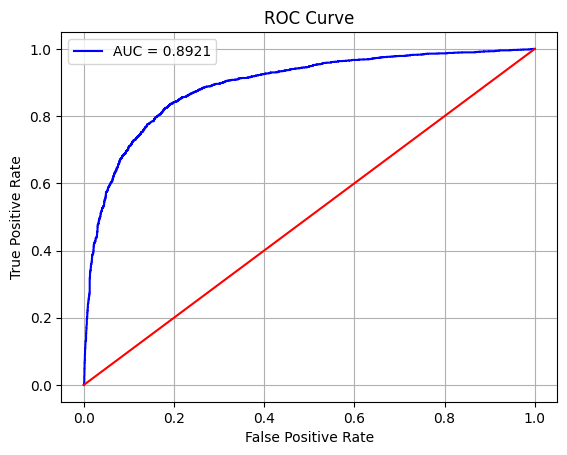

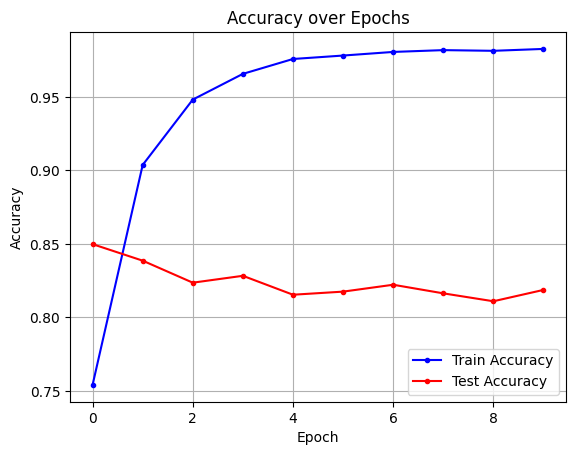

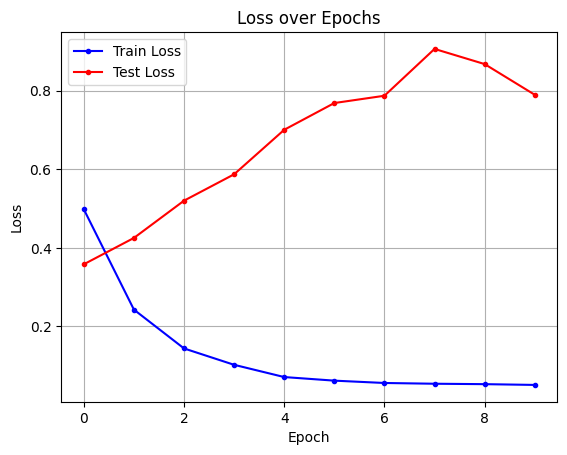

In [19]:
# ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy graph
plt.figure()
plt.plot(history.history['accuracy'], label="Train Accuracy", color='blue', marker='.')
plt.plot(history.history['val_accuracy'], label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(history.history['loss'], label="Train Loss", color='blue', marker='.')
plt.plot(history.history['val_loss'], label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#Persamaan Matematika pada DL

---

##1. RNN
RNN memproses urutan data dengan mempertahankan hidden state dari langkah sebelumnya. Persamaan matematikanya:

$h_t = \tanh(W_h h_{t-1} + W_x x_t + b)$

---

##2. LSTM
LSTM menggunakan tiga gate utama: forget gate, input gate, dan output gate, serta sebuah cell state yang menyimpan memori jangka panjang.

$f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)$ (forget gate)

$i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)$ ,
$\tilde{C}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c)$ (input gate)

$C_t = f_t . C_{t-1} + i_t . \tilde{C}_t$ (update cell state)

$o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)$ (output gate)

$h_t = o_t . \tanh(C_t)$ (hidden state)

---

##3. GRU
GRU menyederhanakan LSTM dengan dua gate.

$z_t = \sigma(W_z x_t + U_z h_{t-1})$ (update gate)

$r_t = σ(W_r x_t + U_r h_{t-1})$ (reset gate)

$\tilde{h_t} = tanh(W_h x_t + U_h (r_t . h_{t-1}))$ (kandidat hidden state)

$h_t = (1 - z_t) . h_{t-1} + z_t . \tilde{h_t}$ (final hidden state)

---

##4. Binary Cross-Entropy Loss
Untuk klasifikasi biner, fungsi loss adalah:

\[
\$mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$\]

($ y_i $): Label sebenarnya (0 atau 1)

($ \hat{y}_i $): Prediksi model

---

#Persamaan Matematika Evaluasi Model Klasifikasi
TP = True Positive

TN = True Negative

FP = False Positive

FN = False Negative

---

##1. Akurasi (Accuracy)
Akurasi mengukur seberapa sering model membuat prediksi yang benar dari keseluruhan data.

Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

---

##2. Presisi (Precision)
Presisi mengukur seberapa akurat prediksi positif yang dibuat oleh model.

$Accuracy = \frac{TP}{TP + FP}$

---

##3. Recall (Sensitivity / True Positive Rate)
Recall mengukur seberapa banyak dari data positif yang berhasil ditangkap oleh model.

$Recall = \frac{TP}{TP + FN}$

---

##4. F1 Score
F1 Score adalah rata-rata harmonik dari precision dan recall.

$F1 = 2 \times \frac{(Precision \times Recall)}{(Precision + Recall)}$

F1 Squared adalah nilai F1 Score dipangkatkan 2.

$F1_{sq} = F1^2$

---

##5. ROC (Receiver Operating Characteristic) Curve
ROC adalah kurva yang menampilkan hubungan antara TPR (True Positive Rate) dan FPR (False Positive Rate).

$TPR = \frac{TP}{TP + FN}$

$FPR = \frac{TP}{FP + TN}$

Kurva ini dibentuk dengan memplot TPR vs FPR pada berbagai threshold klasifikasi.

---

##6. AUC (Area Under Curve):
AUC mengukur luas di bawah kurva ROC. Nilai berkisar antara 0-1. Semakin mendekati 1, semakin baik kemampuan model membedakan kelas positif dan negatif.

---